# Data Pre-Processing for BERT Pre-Training
### Arnav Bhakta in collaboration with Michael Huang on Album Generation

In [168]:
import cv2
import os
import re
import pickle
import matplotlib.pyplot as plt
import tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import torch
from transformers import BertTokenizer, BertForMaskedLM
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json

In [169]:
lyric_set = []
pixels_set = []
path = "./dataset"
dir_list = os.listdir(path)

n = 2
for album in dir_list:
    try:
        path_album = "./dataset"
        path_album += str("/" + album)
        dir_album = os.listdir(path_album)
        cover_path = path_album
        for img in dir_album:
            if ".jpg" in img:
                cover_path += "/" + img
        for song in dir_album:
            if ".txt" in song:
                song_path = path_album + "/" + song
                with open(song_path) as song_lyrics:
                    lines = song_lyrics.readlines()
                    lyric_set.append(lines)
                cover_pixels = cv2.imread(cover_path)
                pixels_set.append(cover_pixels)      
    except:
        pass

In [150]:
lyric_set = [[lyric[:-1] for lyric in lyrics] for lyrics in lyric_set]
lyric_set = [[lyric for lyric in lyrics if lyric != ''] for lyrics in lyric_set]

In [151]:
lyric_set_flattened = []
for ind_song in lyric_set:
    append_song = ""
    for ind_lyric in ind_song:
        append_song += ind_lyric + ", "
    lyric_set_flattened.append(append_song)  
lyric_set_flattened = [lyric[:-2] for lyric in lyric_set_flattened]

In [171]:
lyric_set_flattened[1]

"My mind is full bursting over, With all these things I can't remember, Every little single memory reminds me of you, My eyes were weary with all these tears, You left your shadow in my dreams, And all my doubts seemed to disappear when you came along, Flowers melting up into the sky, Hear my heart where our love collides, We hear the songs we found in the times we lost our way, Gentle memories replace our tears, All the love we had is still right here, We hear the songs we found in the time we lost our way, From without words can not describe, What caused the stars to fall deep inside, Every little single memory reminds me of you, Our days are gone lost forever, Reflecting light glistening under water, Naturally this could be everything that seems so unreal, Flowers melting up into the sky, Hear my heart where our love collides, We hear the songs we found in the time we lost our way, Gentle memories replace our tears, All the love we had is still right here, We hear the songs we found

In [153]:
print(len(pixels_set))
print(len(lyric_set_flattened))

24692
24692


In [154]:
seed = 10
np.random.seed = seed
full_set_lyrics = pd.DataFrame()
full_set_lyrics['lyrics'] = lyric_set_flattened
full_set_lyrics['albums'] = pixels_set
full_set_lyrics = full_set_lyrics.to_numpy()
np.random.shuffle(full_set_lyrics)

In [155]:
lyric_data = full_set_lyrics[:, 0]
image_data = full_set_lyrics[:, 1]
lyric_data_train, lyric_data_test, image_data_train, image_data_test = train_test_split(lyric_data, image_data, 
                                                                                        test_size = 0.2, random_state=1)
lyric_data_train, lyric_data_val, image_data_train, image_data_val = train_test_split(lyric_data_train, image_data_train,
                                                                                     test_size = 0.25,  random_state=1)

In [156]:
vocab_size = 30000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(lyric_data_train)
word_index = tokenizer.word_index
display(word_index)

{'<OOV>': 1,
 'the': 2,
 'i': 3,
 'you': 4,
 'and': 5,
 'to': 6,
 'a': 7,
 'me': 8,
 'it': 9,
 'my': 10,
 'in': 11,
 'of': 12,
 'on': 13,
 'your': 14,
 'that': 15,
 "i'm": 16,
 'all': 17,
 'is': 18,
 'we': 19,
 'for': 20,
 'be': 21,
 'so': 22,
 "don't": 23,
 'but': 24,
 'like': 25,
 'with': 26,
 'this': 27,
 'know': 28,
 'up': 29,
 "it's": 30,
 'no': 31,
 'just': 32,
 'what': 33,
 'when': 34,
 'love': 35,
 'chorus': 36,
 'verse': 37,
 'oh': 38,
 'get': 39,
 'got': 40,
 'now': 41,
 'do': 42,
 'can': 43,
 'out': 44,
 'if': 45,
 'down': 46,
 'they': 47,
 'go': 48,
 'was': 49,
 'one': 50,
 "you're": 51,
 'see': 52,
 'are': 53,
 'time': 54,
 'not': 55,
 'yeah': 56,
 'never': 57,
 'will': 58,
 'from': 59,
 'want': 60,
 'have': 61,
 'at': 62,
 'she': 63,
 'back': 64,
 "can't": 65,
 'come': 66,
 'baby': 67,
 'say': 68,
 'let': 69,
 'take': 70,
 'make': 71,
 'way': 72,
 'as': 73,
 'how': 74,
 'her': 75,
 "i'll": 76,
 'he': 77,
 'here': 78,
 '1': 79,
 '2': 80,
 'right': 81,
 "ain't": 82,
 'there

In [157]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [158]:
lyric_data_train_tokenized = tokenizer.texts_to_sequences(lyric_data_train)
lyric_data_test_tokenized = tokenizer.texts_to_sequences(lyric_data_test)
lyric_data_val_tokenized = tokenizer.texts_to_sequences(lyric_data_val)

In [159]:
max_lyric_len = 0
max_lyric_len_count = 0
len_lyric_set_flattened = []

for lyric in lyric_set_flattened:
    len_lyric_set_flattened.append(len(lyric))

for full_lyric_len in len_lyric_set_flattened:
    full_lyric_len_frequency = len_lyric_set_flattened.count(full_lyric_len)
    if full_lyric_len_frequency > max_lyric_len_count:
        max_lyric_len_count = full_lyric_len_frequency
        max_lyric_len = full_lyric_len

In [160]:
print("most frequent lyric length:", max_lyric_len)
print("count of the most frequent lyric length:", max_lyric_len_count)

most frequent lyric length: 14
count of the most frequent lyric length: 493


In [161]:
len_lyric_set_flattened.sort()
length_lyric_len_set = len(len_lyric_set_flattened)
mid_length = length_lyric_len_set // 2
median_length = 0

if length_lyric_len_set % 2 == 0:
    medR = len_lyric_set_flattened[mid_length]
    medL = len_lyric_set_flattened[mid_length - 1]
    median_length = (medR + medL) / 2
else:
    median_length = len_lyric_set_flattened[mid_length]

print("median lyric length:", median_length)

median lyric length: 1114.0


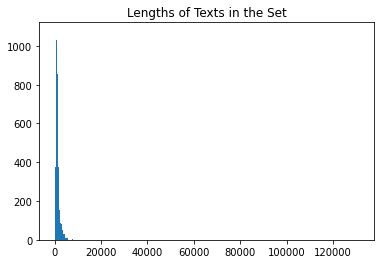

In [162]:
len_lyrics = []
for lyric in lyric_set_flattened:
    len_lyrics.append(len(lyric))

plt.hist(len_lyrics, bins='auto')
plt.title("Lengths of Texts in the Set")
plt.show()

In [163]:
median_length = int(median_length)
lyric_data_train_padded = pad_sequences(lyric_data_train_tokenized, maxlen = median_length, 
                                        padding = 'post', truncating = 'post')
lyric_data_test_padded = pad_sequences(lyric_data_test_tokenized, maxlen = median_length, 
                                        padding = 'post', truncating = 'post')
lyric_data_val_padded = pad_sequences(lyric_data_val_tokenized, maxlen = median_length, 
                                        padding = 'post', truncating = 'post')

In [164]:
lyric_set_flattened_padded = []
lyric_set_flattened_padded.extend(lyric_data_train_padded)
lyric_set_flattened_padded.extend(lyric_data_test_padded)
lyric_set_flattened_padded.extend(lyric_data_val_padded)

In [165]:
scale_pct = 40
for img_resize in pixels_set:
    try:
        wdth = int(img_resize.shape[0] * scale_pct / 100)
        hgt = int(img_resize.shape[1] * scale_pct / 100)
        dim = (wdth, hgt)
        img_resize = cv2.resize(img_resize, dim, interpolation = cv2.INTER_AREA)
    except:
        pass

In [166]:
full_set = [lyric_set_flattened_padded, pixels_set]

In [167]:
with open('dataset.pkl','wb') as f:
    pickle.dump(full_set, f)